In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,confusion_matrix,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC  
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer, CountVectorizer
from sklearn.externals import joblib
import gensim
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)
import nltk

%matplotlib inline

D:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Loading the Train data
def load_train():
    df = pd.read_csv('../Hackathon3/data/train.csv')
    df = df[['tweet', 'sentiment']]
    df = df.dropna()
#     print(df.info())
    return df

df = load_train()
df.head()

,tweet,sentiment
0,#sxswnui #sxsw #apple defining language of touch with different dialects becoming smaller,1
1,"Learning ab Google doodles! All doodles should be light, funny &amp; innovative, with exceptions for significant occasions. #GoogleDoodle #sxsw",1
2,"one of the most in-your-face ex. of stealing the show in yrs RT @mention &quot;At #SXSW, Apple schools the mkt experts&quot; {link}",2
3,This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork,0
4,Line outside the Apple store in Austin waiting for the new iPad #SXSW {link},1


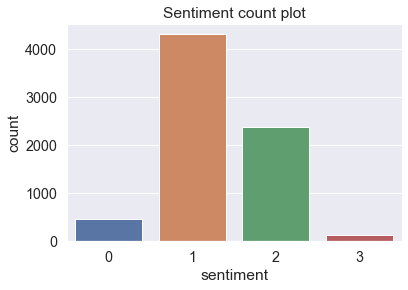

In [3]:
# create countplot for Target column
def createCP(df,x1):
    sns.countplot(x = x1, data = df)
    plt.title('Sentiment count plot')
    plt.show()

x = df.columns.tolist()[-1]   # last column is Target 'sentiment''
createCP(df, "sentiment")

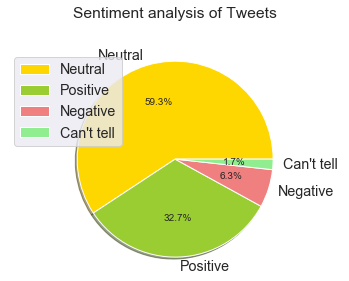

In [4]:
sentiments = [4311,2382,456,125]
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightgreen', 'pink']
my_labels = 'Neutral','Positive','Negative',"Can't tell"
plt.pie(sentiments,labels=my_labels,autopct='%1.1f%%',shadow=True,colors=colors_list)
plt.title('Sentiment analysis of Tweets', y=1.12) 
plt.axis('equal') 
plt.legend(labels=my_labels, loc='upper left') 
plt.axis('equal')
plt.show()

In [5]:
#Loading the Test data
def load_test():
    df = pd.read_csv('../Hackathon3/data/test.csv')
    df = df[['tweet_id','tweet']]
#     print(df.info())
    return df

dftest = load_test()
df1 = dftest[['tweet']]
df1.head()

,tweet
0,"Audience Q: What prototyping tools do you use? Sketchbooks/sharpie pens, photoshop, Balsamic, Google docs, Axsure, etc. #myprototype #sxsw"
1,At SXSW? Send Your Best Photos &amp; Videos to... {link} #citizen_journalism #cnn #ireport #photography #sxsw #Cyber #iPhone
2,@mention and here's a pic of you winning your ipad! #unsix #sxsw cc @mention @mention {link} (cont) {link}
3,Google Marissa Mayer: mobile phone as a cursor of physical location - new version of map fast and more real life like #sxsw
4,#SXSW Google maps is even cooler than I thought


In [6]:
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self

    def transform(self, X, **transform_params):
        def has_long(sentence):
            a = []
            for x in sentence.split():
                if re.compile("([a-zA-Z])\\1{2,}").search(x):
                    a.append(x)
            return a
        def isalpha(stre):
            countl=0
            for i in stre:
                if i.isalpha():
                    countl+=1
            return countl
        def isdig(stre):
            countn=0
            for i in stre:
                if i.isdigit():
                    countn+=1
            return countn
        fstcap = X.apply(lambda a:len([''.join(c) for c in a.strip().split() if c[0].isupper()])) # list of first capital letter
        elgwrd = X.apply(lambda a:len(has_long(a))) # list of Elongated word
        NofChr = X.apply(lambda a:isalpha(a)) # number of character
        Nofdgt = X.apply(lambda a:isdig(a)) # number of digit
        count_words = X.apply(lambda x: self.count_regex(r'\w+', str(x)))   # count word 
        count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', str(x)))  # count mentions
        count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', str(x)))  # count hashtags
        count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', str(x)))   # count uppercase words
        count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', str(x)))     # count exclametory mark
        count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', str(x)))  # count urls
        # We will replace the emoji symbols with a description, which makes using a regex for counting easier
        # Moreover, it will result in having more words in the tweet
        count_emojis = X.apply(lambda x: emoji.demojize(str(x))).apply(lambda x: self.count_regex(r':[a-z_&]+:', str(x)))
        
        df = pd.DataFrame({'count_words': count_words
                           , 'count_char': NofChr
                           , 'count_digit': Nofdgt
                           , 'count_mentions': count_mentions
                           , 'count_hashtags': count_hashtags
                           , 'count_capital_words': count_capital_words
                           , 'count_fCap': fstcap
                           , 'count_Elgwords': elgwrd
                           , 'count_excl_quest_marks': count_excl_quest_marks
                           , 'count_urls': count_urls
                           , 'count_emojis': count_emojis
                          })
        
        return df


In [7]:
class CleanText(BaseEstimator, TransformerMixin):
    def remove_mentions(self, input_text):
        return re.sub(r'@\w+', '', str(input_text))
    
    def remove_urls(self, input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', str(input_text))
    
    def emoji_oneword(self, input_text):
        # By compressing the underscore, the emoji is kept as one word
        return input_text.replace('_','')
    
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    def remove_digits(self, input_text):
        return re.sub('\d+', '', str(input_text))
    
    def to_lower(self, input_text):
        return input_text.lower()
    
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
#     def stemming(self, input_text):
#         porter = PorterStemmer()
#         words6 = input_text.split() 
#         stemmed_words = [porter.stem(word) for word in words]
#         return " ".join(stemmed_words)
    
    def lemmatization(self,input_text):
        words = input_text.split() 
        lemma = WordNetLemmatizer()
        lemma_words = [lemma.lemmatize(i) for i in words]
        return " ".join(lemma_words)  
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits).apply(self.to_lower).apply(self.remove_stopwords).apply(self.lemmatization)
        return clean_X

In [8]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Rushabh A.
[nltk_data]     Bharadva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
df = load_train()  # load train data
df1 = load_test() # load test data

# create numerical feature for train
tc = TextCounts()
df_train = tc.fit_transform(df['tweet'])
df_train['sentiment'] = df.sentiment
# create numerical feature for test
df_test = tc.fit_transform(df1['tweet'])
# clean text for train 
ct = CleanText()
train_clean = ct.fit_transform(df['tweet'])
# clean text for test 
ct = CleanText()
test_clean = ct.fit_transform(df1['tweet'])

df_model = df_train
df_model['clean_text'] = train_clean
df1_model = df_test
df1_model['clean_text'] = test_clean

In [10]:
train_clean.sample(5)

7180    packing point showing iphone fragmentation sxsw                                                
770     sxsw crowd austin swarm ipad launch link via sadly one                                         
1721    ze frank project walk google streetview street walked many time revelation pop sxsw            
4262    anyone know able find video marissa mayer sxsw presentation google                             
6493    ipad giveaway full force person friend city end sxsw win hint strong email list work well sxswi
Name: tweet, dtype: object

In [11]:
empty_clean = train_clean == ''
print('{} records have no words left after text cleaning'.format(train_clean[empty_clean].count()))
train_clean.loc[empty_clean] = '[no_text]'

0 records have no words left after text cleaning


In [12]:
df_model.head()

,count_words,count_char,count_digit,count_mentions,count_hashtags,count_capital_words,count_fCap,count_Elgwords,count_excl_quest_marks,count_urls,count_emojis,sentiment,clean_text
0,12,75,0,0,3,0,0,0,0,0,0,1,sxswnui sxsw apple defining language touch different dialect becoming smaller
1,19,117,0,0,2,0,3,0,1,0,0,1,learning ab google doodle doodle light funny amp innovative exception significant occasion googledoodle sxsw
2,26,98,0,1,1,2,2,0,0,0,0,2,one face ex stealing show yr rt quot sxsw apple school mkt expert quot link
3,20,100,2,0,3,1,1,0,0,0,0,0,iphone sxsw app would pretty awesome crash every min extended browsing fuckit illmakeitwork
4,14,60,0,0,1,1,3,0,0,0,0,1,line outside apple store austin waiting new ipad sxsw link


In [13]:
df1_model.head()

,count_words,count_char,count_digit,count_mentions,count_hashtags,count_capital_words,count_fCap,count_Elgwords,count_excl_quest_marks,count_urls,count_emojis,clean_text
0,19,110,0,0,2,0,7,0,1,0,0,audience prototyping tool use sketchbook sharpie pen photoshop balsamic google doc axsure etc myprototype sxsw
1,17,92,0,0,7,1,7,0,1,0,0,sxsw send best photo amp video link citizenjournalism cnn ireport photography sxsw cyber iphone
2,19,76,0,3,2,0,0,0,1,0,0,pic winning ipad unsix sxsw cc link cont link
3,22,98,0,0,1,0,3,0,0,0,0,google marissa mayer mobile phone cursor physical location new version map fast real life like sxsw
4,9,38,0,0,1,1,2,0,0,0,0,sxsw google map even cooler thought


In [14]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rushabh A.
[nltk_data]     Bharadva\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [15]:
#POS TAG
from nltk import pos_tag
tagged_titles = df_model['clean_text'].str.split().map(pos_tag)

# Creating a dataframe
tagged_titles_df = pd.DataFrame(tagged_titles) 
tagged_titles_df 

,clean_text
0,"[(sxswnui, NN), (sxsw, NN), (apple, NN), (defining, VBG), (language, NN), (touch, JJ), (different, JJ), (dialect, NN), (becoming, VBG), (smaller, JJR)]"
1,"[(learning, VBG), (ab, JJ), (google, NN), (doodle, NN), (doodle, NN), (light, JJ), (funny, JJ), (amp, NN), (innovative, JJ), (exception, NN), (significant, JJ), (occasion, NN), (googledoodle, NN), (sxsw, NN)]"
2,"[(one, CD), (face, NN), (ex, NN), (stealing, VBG), (show, NN), (yr, JJ), (rt, NN), (quot, NN), (sxsw, NN), (apple, NN), (school, NN), (mkt, NN), (expert, NN), (quot, NN), (link, NN)]"
3,"[(iphone, NN), (sxsw, NN), (app, NN), (would, MD), (pretty, VB), (awesome, JJ), (crash, NN), (every, DT), (min, NN), (extended, VBD), (browsing, VBG), (fuckit, NN), (illmakeitwork, NN)]"
4,"[(line, NN), (outside, IN), (apple, NN), (store, NN), (austin, NN), (waiting, VBG), (new, JJ), (ipad, JJ), (sxsw, NN), (link, NN)]"
...,...
7269,"[(google, NN), (plze, NN), (tammi, NN), (middle, JJ), (sxsw, JJ), (craziness, NN), (everything, NN), (soooooo, NN), (busy, JJ)]"
7270,"[(rt, NN), (÷¼, NN), (set, VBN), (÷, NNP), (link, VBP), (÷, NNP), (edchat, WP), (musedchat, VBD), (sxsw, JJ), (sxswi, NN), (newtwitter, NN)]"
7271,"[(rt, NN), (aha, NN), (found, VBD), (proof, JJ), (lactation, NN), (room, NN), (excuse, IN), (quot, JJ), (mother, NN), (room, NN), (quot, NN), (brought, VBD), (google, NN), (last, JJ), (year, NN), (sxsw, VBD), (link, NN)]"
7272,"[(launched, VBN), (ipad, NN), (app, NN), (sxsw, NN), (get, VB), (detail, NN), (first, JJ), (edition, NN), (free, JJ), (link, NN)]"


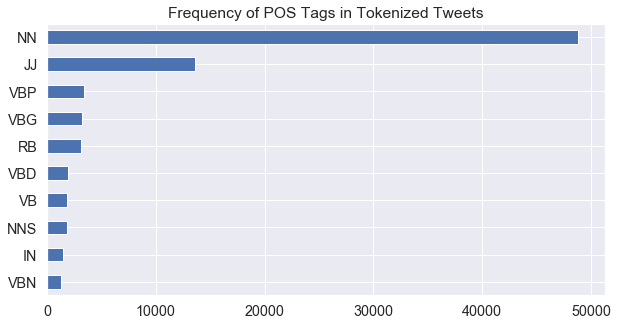

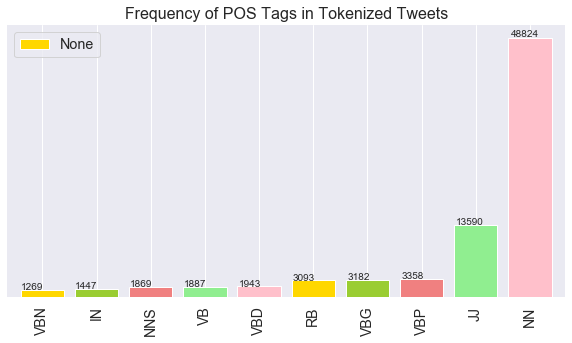

In [16]:
# Function to create tags

def count_tags(title_with_tags):
    tag_count = {}
    for word, tag in title_with_tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return(tag_count)


# Mapping the counts with the tags
tagged_titles_df['tag_counts'] = tagged_titles_df['clean_text'].map(count_tags)


# Tagset containing all the possible tags
tag_set = list(set([tag for tags in tagged_titles_df['tag_counts'] for tag in tags]))

# Creating tag column frequency for each tags
for tag in tag_set:
    tagged_titles_df[tag] = tagged_titles_df['tag_counts'].map(lambda x: x.get(tag, 0))


# Subsetting the dataframe to contain only the tagset columns    
top_pos=tagged_titles_df[tag_set]

# Sorting and storing the top 10 frequent tags
top_pos=top_pos.sum().sort_values().tail(10)
    
    
# Plotting the barplot of the tag frequency   
title = 'Frequency of POS Tags in Tokenized Tweets'    
top_pos.plot(kind='barh', figsize=(10,5), title=title)


plt.show()

ax = top_pos.plot(kind='bar',figsize=(10,5),width = 0.8,color = colors_list,legend=True)

plt.title("Frequency of POS Tags in Tokenized Tweets",fontsize= 16)

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate( '{:.0%}'.format(height),(x, y + height + 0.01))
for p in ax.patches:
   ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

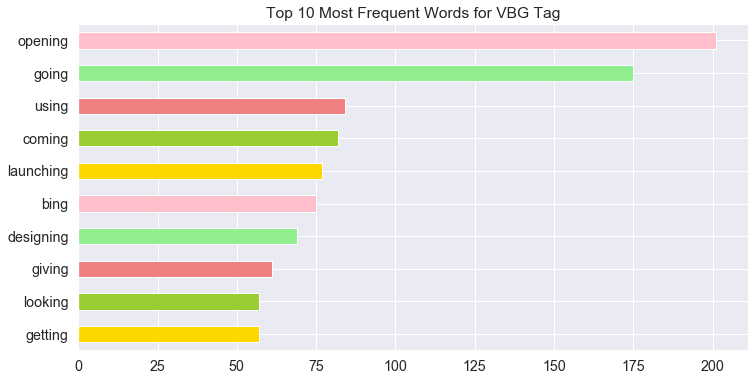

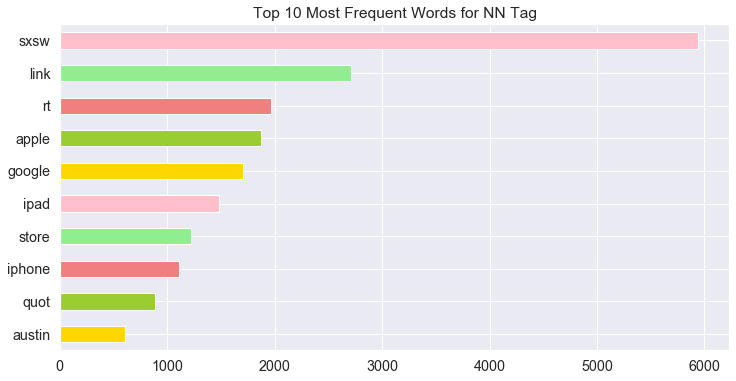

In [17]:
#MOST FREQUEST VBG and NN tag
# Function to create vocabulary of the tags
def vocab_creator(tagged_titles):
    vocab = {}

    for row in tagged_titles['clean_text']:
        for word, tag in row:
            if word in vocab:
                if tag in vocab[word]:
                    vocab[word][tag] += 1
                else:
                    vocab[word][tag] = 1
            else:
                vocab[word] = {tag: 1}
            
    return vocab    
            
# Creating vocab of our tagged titles dataframe
vocab= vocab_creator(tagged_titles_df)

# Creating dataframe from vocab dictionary
vocab_df = pd.DataFrame.from_dict(vocab,orient='index')

# Fill the nan values of dataframe
vocab_df.fillna(value=0, inplace=True)

# Saving the top 10 most frequent VBG taggged words
size = 10
tag = 'VBG' 
top_verb_nominee=vocab_df[tag].sort_values().tail(size)
colors_list1=["lightye"]
# Plotting the top 10 most frequent VBG taggged words 
title = 'Top {} Most Frequent Words for {} Tag'.format(size, tag)
top_verb_nominee.plot(kind='barh', figsize=(12,6), title=title,color = colors_list)
plt.show()

# Saving the top 10 most frequent NN taggged words
size = 10
tag = 'NN' 
top_noun_nominee=vocab_df[tag].sort_values().tail(size)
colors_list2=["indigo"]
# Plotting the top 10 most frequent NN taggged words 
title = 'Top {} Most Frequent Words for {} Tag'.format(size, tag)
top_noun_nominee.plot(kind='barh', figsize=(12,6), title=title,color = colors_list)
plt.show()

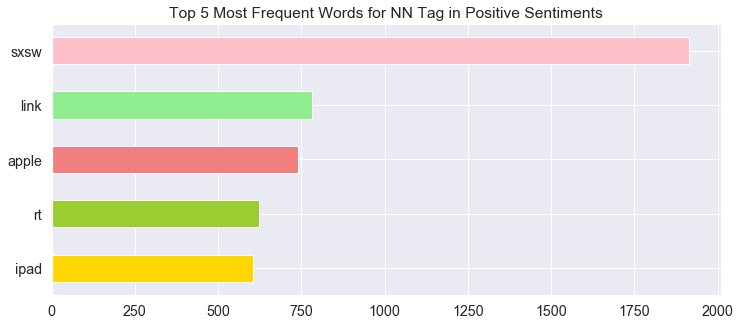

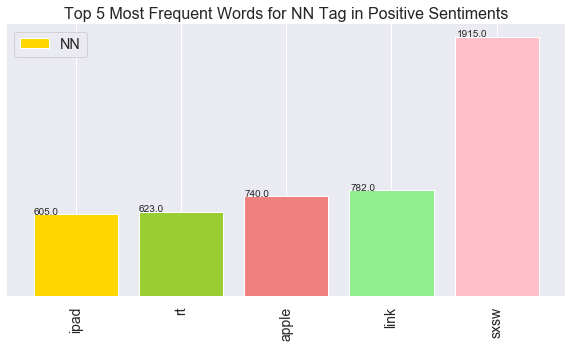

In [18]:
#MOST Frequent NNP Tags in positive sentiments 
new_df=df_model[(df_model['sentiment']==2) & (df_model['clean_text'])]

tagged_titles_senti= new_df['clean_text'].str.split().map(pos_tag)

# Creating a dataframe
tagged_titles_senti_df=pd.DataFrame(tagged_titles_senti)

# Creating a vocabulary of the tags
vocab= vocab_creator(tagged_titles_senti_df)

# Creating a dataframe from the dictionary
vocab_df = pd.DataFrame.from_dict(vocab,orient='index')

# Filling the nan values in the dataframe
vocab_df.fillna(value=0, inplace=True)

# Saving the top 5 most frequent NNP taggged words
size = 5
tag = 'NN' 
top_proper_noun=vocab_df[tag].sort_values().tail(size)


# Plotting the top 5 most frequent NNP taggged words
title = 'Top {} Most Frequent Words for {} Tag in Positive Sentiments'.format(size, tag)
top_proper_noun.plot(kind='barh', figsize=(12,5), title=title,color = colors_list)
plt.show()


ax = top_proper_noun.plot(kind='bar',figsize=(10,5),width = 0.8,color = colors_list,legend=True)

plt.title("Top 5 Most Frequent Words for NN Tag in Positive Sentiments",fontsize= 16)

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate( '{:.0%}'.format(height),(x, y + height + 0.01))
for p in ax.patches:
   ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


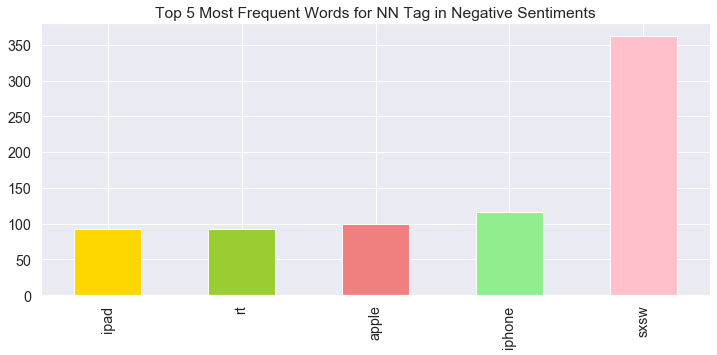

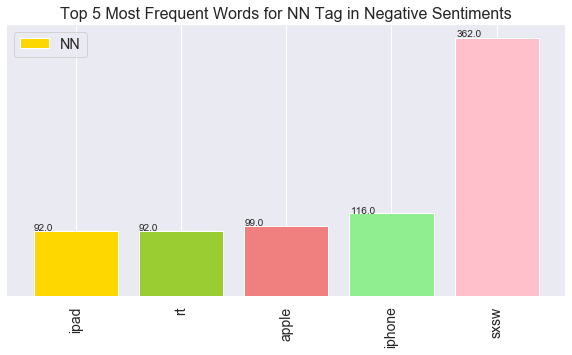

In [19]:
#MOST Frequent NN Tags in Negative sentiments
new_df=df_model[(df_model['sentiment']==0) & (df_model['clean_text'])]

tagged_titles_senti= new_df['clean_text'].str.split().map(pos_tag)

# Creating a dataframe
tagged_titles_senti_df=pd.DataFrame(tagged_titles_senti)

# Creating a vocabulary of the tags
vocab= vocab_creator(tagged_titles_senti_df)

# Creating a dataframe from the dictionary
vocab_df = pd.DataFrame.from_dict(vocab,orient='index')

# Filling the nan values in the dataframe
vocab_df.fillna(value=0, inplace=True)

# Saving the top 5 most frequent NNP taggged words
size = 5
tag = 'NN' 
top_proper_noun=vocab_df[tag].sort_values().tail(size)


# Plotting the top 5 most frequent NNP taggged words
title = 'Top {} Most Frequent Words for {} Tag in Negative Sentiments'.format(size, tag)
top_proper_noun.plot(kind='bar', figsize=(12,5), title=title,color = colors_list)
plt.show()

ax = top_proper_noun.plot(kind='bar',figsize=(10,5),width = 0.8,color = colors_list,legend=True)

plt.title("Top 5 Most Frequent Words for NN Tag in Negative Sentiments",fontsize= 16)

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate( '{:.0%}'.format(height),(x, y + height + 0.01))
for p in ax.patches:
   ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

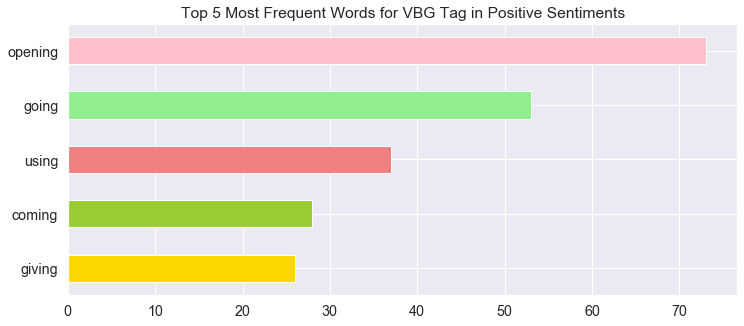

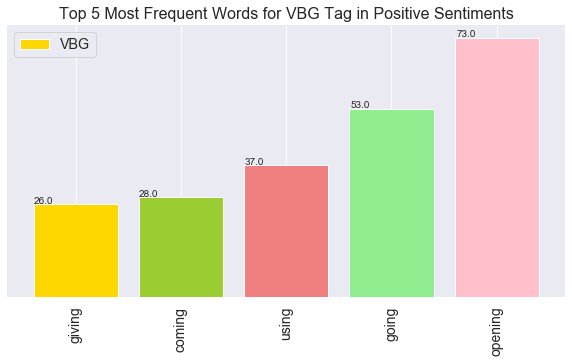

In [20]:
#Most frequesnt VBG tags in positive sentiments
new_df=df_model[(df_model['sentiment']==2) & (df_model['clean_text'])]

tagged_titles_senti= new_df['clean_text'].str.split().map(pos_tag)

# Creating a dataframe
tagged_titles_senti_df=pd.DataFrame(tagged_titles_senti)

# Creating a vocabulary of the tags
vocab= vocab_creator(tagged_titles_senti_df)

# Creating a dataframe from the dictionary
vocab_df = pd.DataFrame.from_dict(vocab,orient='index')

# Filling the nan values in the dataframe
vocab_df.fillna(value=0, inplace=True)

# Saving the top 5 most frequent NNP taggged words
size = 5
tag = 'VBG' 
top_proper_noun=vocab_df[tag].sort_values().tail(size)


# Plotting the top 5 most frequent NNP taggged words
title = 'Top {} Most Frequent Words for {} Tag in Positive Sentiments'.format(size, tag)
top_proper_noun.plot(kind='barh', figsize=(12,5), title=title,color = colors_list)
plt.show()


ax = top_proper_noun.plot(kind='bar',figsize=(10,5),width = 0.8,color = colors_list,legend=True)

plt.title("Top {} Most Frequent Words for {} Tag in Positive Sentiments".format(size, tag),fontsize= 16)

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate( '{:.0%}'.format(height),(x, y + height + 0.01))
for p in ax.patches:
   ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))



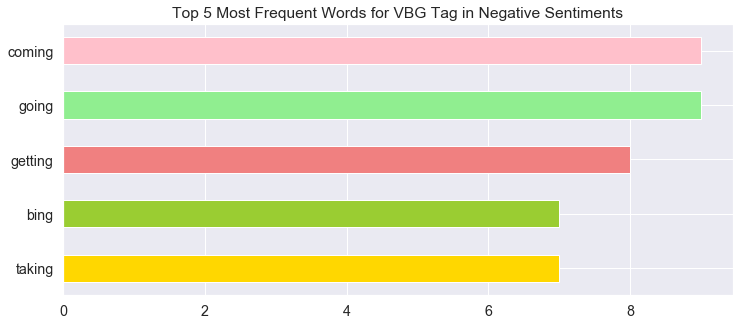

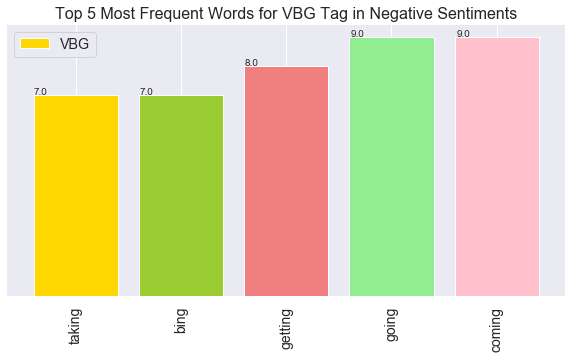

In [21]:
#Most frequesnt VBG tags in negative sentiments
new_df=df_model[(df_model['sentiment']==0) & (df_model['clean_text'])]

tagged_titles_senti= new_df['clean_text'].str.split().map(pos_tag)

# Creating a dataframe
tagged_titles_senti_df=pd.DataFrame(tagged_titles_senti)

# Creating a vocabulary of the tags
vocab= vocab_creator(tagged_titles_senti_df)

# Creating a dataframe from the dictionary
vocab_df = pd.DataFrame.from_dict(vocab,orient='index')

# Filling the nan values in the dataframe
vocab_df.fillna(value=0, inplace=True)

# Saving the top 5 most frequent NNP taggged words
size = 5
tag = 'VBG' 
top_proper_noun=vocab_df[tag].sort_values().tail(size)


# Plotting the top 5 most frequent NNP taggged words
title = 'Top {} Most Frequent Words for {} Tag in Negative Sentiments'.format(size, tag)
top_proper_noun.plot(kind='barh', figsize=(12,5), title=title,color = colors_list)
plt.show()


ax = top_proper_noun.plot(kind='bar',figsize=(10,5),width = 0.8,color = colors_list,legend=True)

plt.title("Top {} Most Frequent Words for {} Tag in Negative Sentiments".format(size, tag),fontsize= 16)

plt.xticks(fontsize=14)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.yticks([])

# Add this loop to add the annotations
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy() 
#     ax.annotate( '{:.0%}'.format(height),(x, y + height + 0.01))
for p in ax.patches:
   ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))



Descriptive stats for count_words
---------------------------------
            count       mean       std  min   25%   50%   75%   max
sentiment                                                          
0          456.0   19.500000  5.405736  6.0  16.0  20.0  24.0  32.0
1          4310.0  18.045012  5.223198  2.0  14.0  18.0  22.0  41.0
2          2382.0  18.863980  5.289912  4.0  15.0  19.0  23.0  35.0
3          125.0   18.152000  5.296158  8.0  14.0  18.0  22.0  30.0


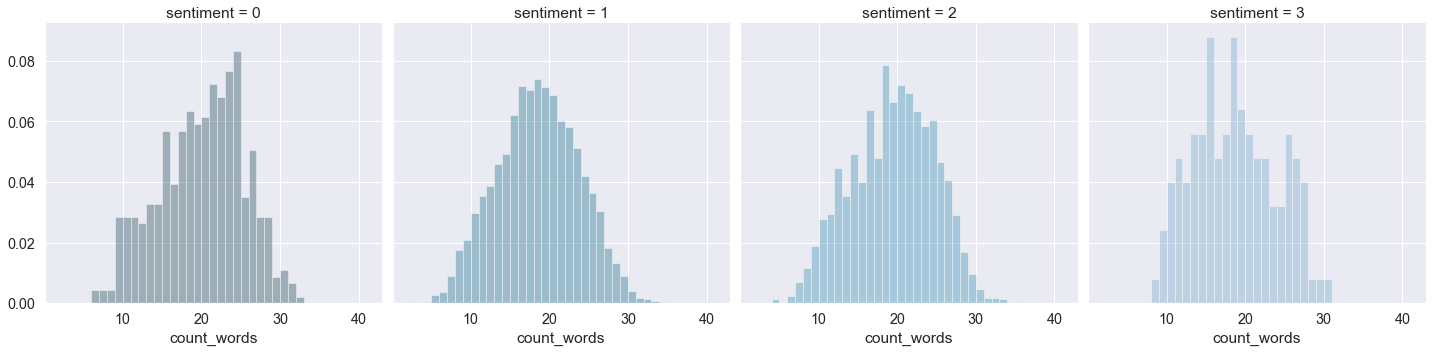

Descriptive stats for count_mentions
------------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.552632  0.739374  0.0  0.0  0.0  1.0  4.0
1          4310.0  0.850348  0.976455  0.0  0.0  1.0  1.0  8.0
2          2382.0  0.740134  0.838025  0.0  0.0  1.0  1.0  5.0
3          125.0   0.640000  0.962188  0.0  0.0  0.0  1.0  5.0


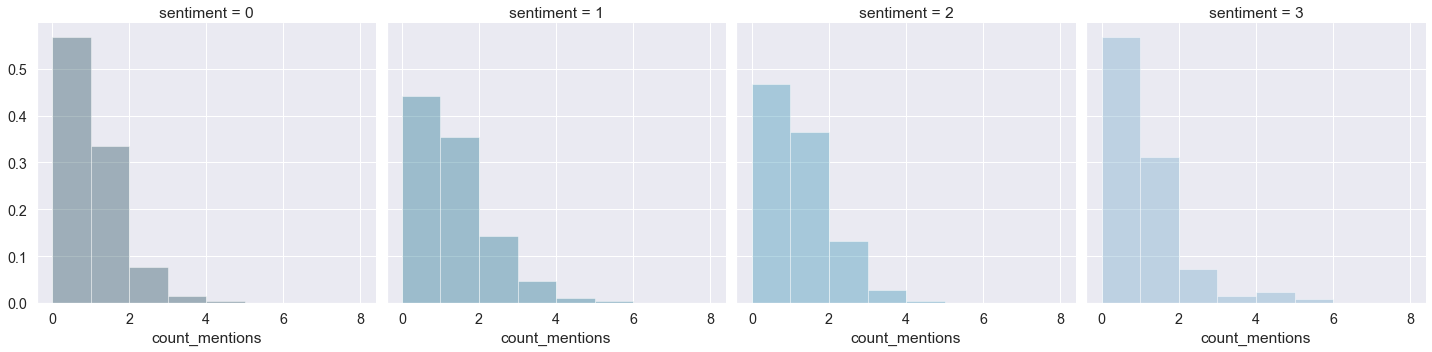

Descriptive stats for count_hashtags
------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   1.605263  0.839868  1.0  1.0  1.0  2.0  6.0 
1          4310.0  1.792575  1.180463  0.0  1.0  1.0  2.0  12.0
2          2382.0  1.683039  0.952835  0.0  1.0  1.0  2.0  7.0 
3          125.0   1.600000  0.950382  1.0  1.0  1.0  2.0  5.0 


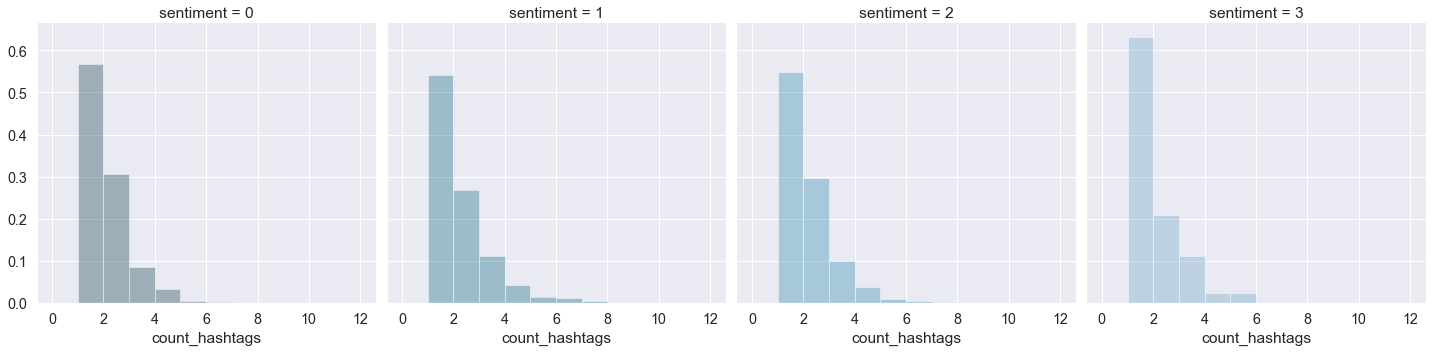

Descriptive stats for count_capital_words
-----------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.901316  1.199413  0.0  0.0  1.0  1.0  18.0
1          4310.0  1.110209  1.060554  0.0  0.0  1.0  2.0  17.0
2          2382.0  1.033165  0.963940  0.0  0.0  1.0  2.0  6.0 
3          125.0   0.976000  0.919888  0.0  0.0  1.0  1.0  4.0 


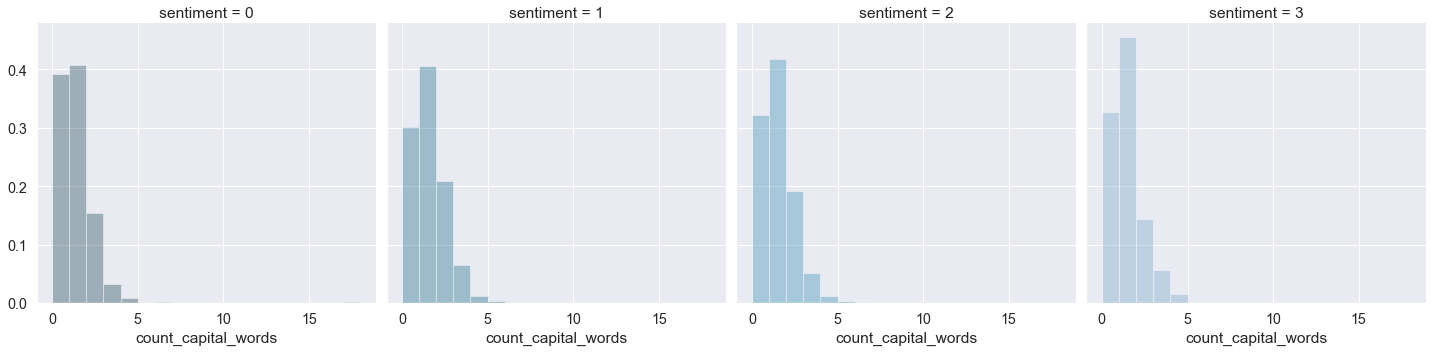

Descriptive stats for count_excl_quest_marks
--------------------------------------------
            count      mean       std  min  25%  50%  75%   max
sentiment                                                      
0          456.0   0.361842  0.819134  0.0  0.0  0.0  0.0  8.0 
1          4310.0  0.406265  0.767710  0.0  0.0  0.0  1.0  11.0
2          2382.0  0.548699  0.903084  0.0  0.0  0.0  1.0  9.0 
3          125.0   0.424000  0.825638  0.0  0.0  0.0  1.0  3.0 


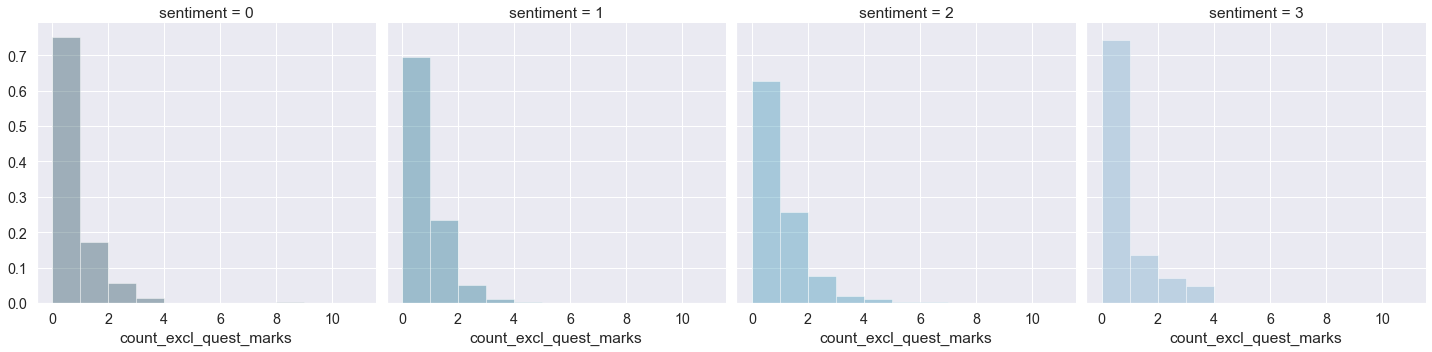

Descriptive stats for count_urls
--------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4310.0  0.001624  0.040272  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.004618  0.067813  0.0  0.0  0.0  0.0  1.0
3          125.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


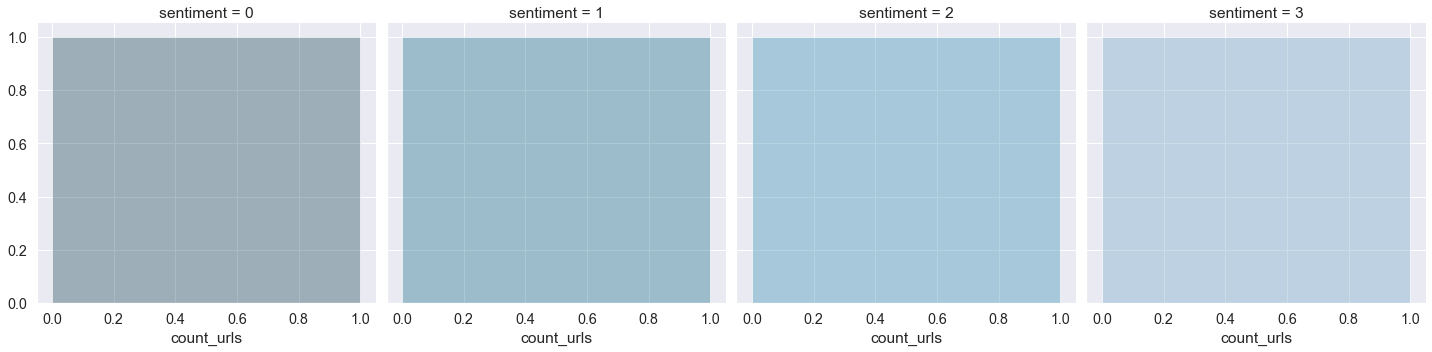

Descriptive stats for count_emojis
----------------------------------
            count      mean       std  min  25%  50%  75%  max
sentiment                                                     
0          456.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0
1          4310.0  0.001624  0.040272  0.0  0.0  0.0  0.0  1.0
2          2382.0  0.001259  0.035474  0.0  0.0  0.0  0.0  1.0
3          125.0   0.000000  0.000000  0.0  0.0  0.0  0.0  0.0


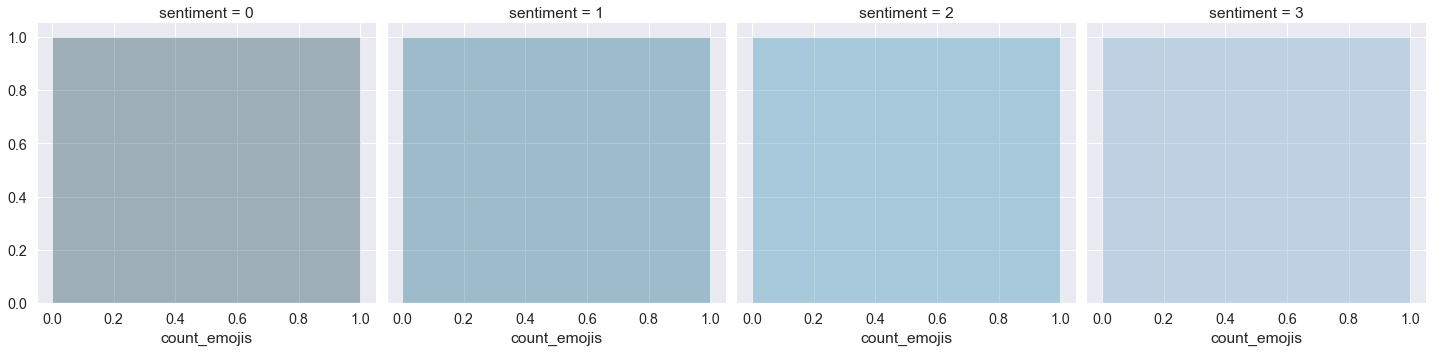

In [22]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('sentiment')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='sentiment', size=5, hue='sentiment', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()
    
df_eda = df_model
show_dist(df_eda, 'count_words')
show_dist(df_eda, 'count_mentions')
show_dist(df_eda, 'count_hashtags')
show_dist(df_eda, 'count_capital_words')
show_dist(df_eda, 'count_excl_quest_marks')
show_dist(df_eda, 'count_urls')
show_dist(df_eda, 'count_emojis')

In [23]:
from skimage import io
# function for wordcloud 
def createWC(df):
    
    url = "C:/Users/Rushabh A. Bharadva/Desktop/Komal/Hackathon3/twitter_mask.png"
    mask = io.imread(url)

    tweet_all = " ".join(i for i in df.tweet)
    tweet_0 = " ".join(i for i in df[df['sentiment']==0].tweet)
    tweet_1 = " ".join(i for i in df[df['sentiment']==1].tweet)
    tweet_2 = " ".join(i for i in df[df['sentiment']==2].tweet)
    tweet_3 = " ".join(i for i in df[df['sentiment']==3].tweet)

    fig, ax = plt.subplots(5, 1, figsize  = (40,40))
    # Create and generate a word cloud image:
    wc_all = WordCloud(max_font_size=60, max_words=100, background_color="white",mask=mask,contour_width=1).generate(tweet_all)
    wc_0 = WordCloud(max_font_size=60, max_words=100, background_color="white",mask=mask,contour_width=1).generate(tweet_0)
    wc_1 = WordCloud(max_font_size=60, max_words=100, background_color="white",mask=mask,contour_width=1).generate(tweet_1)
    wc_2 = WordCloud(max_font_size=60, max_words=100, background_color="white",mask=mask,contour_width=1).generate(tweet_2)
    wc_3 = WordCloud(max_font_size=60, max_words=100, background_color="white",mask=mask,contour_width=1).generate(tweet_3)

    # 0: Negative,  1: Neutral, 2: Positive, 3: Can't Tell
    # Display the generated image:

    ax[0].imshow(wc_all, interpolation='bilinear')
    ax[0].set_title('All Tweets', fontsize=40)
    ax[0].axis('off')
    wc_all.to_file('wc_all.png')
    ax[1].imshow(wc_0, interpolation='bilinear')
    ax[1].set_title('Tweets under Negative Sentiment',fontsize=40)
    ax[1].axis('off')
#     wc_0.to_file('wc_0.png')
    ax[2].imshow(wc_1, interpolation='bilinear')
    ax[2].set_title('Tweets under Neutral Sentiment',fontsize=40)
    ax[2].axis('off')
#     wc_1.to_file('wc_1.png')
    ax[3].imshow(wc_2, interpolation='bilinear')
    ax[3].set_title('Tweets under Positive Sentiment',fontsize=40)
    ax[3].axis('off')
#     wc_2.to_file('wc_2.png')
    ax[4].imshow(wc_3, interpolation='bilinear')
    ax[4].set_title('Tweets under Can\'t Tell Sentiment',fontsize=40)
    ax[4].axis('off')
#     wc_3.to_file('wc_3.png')


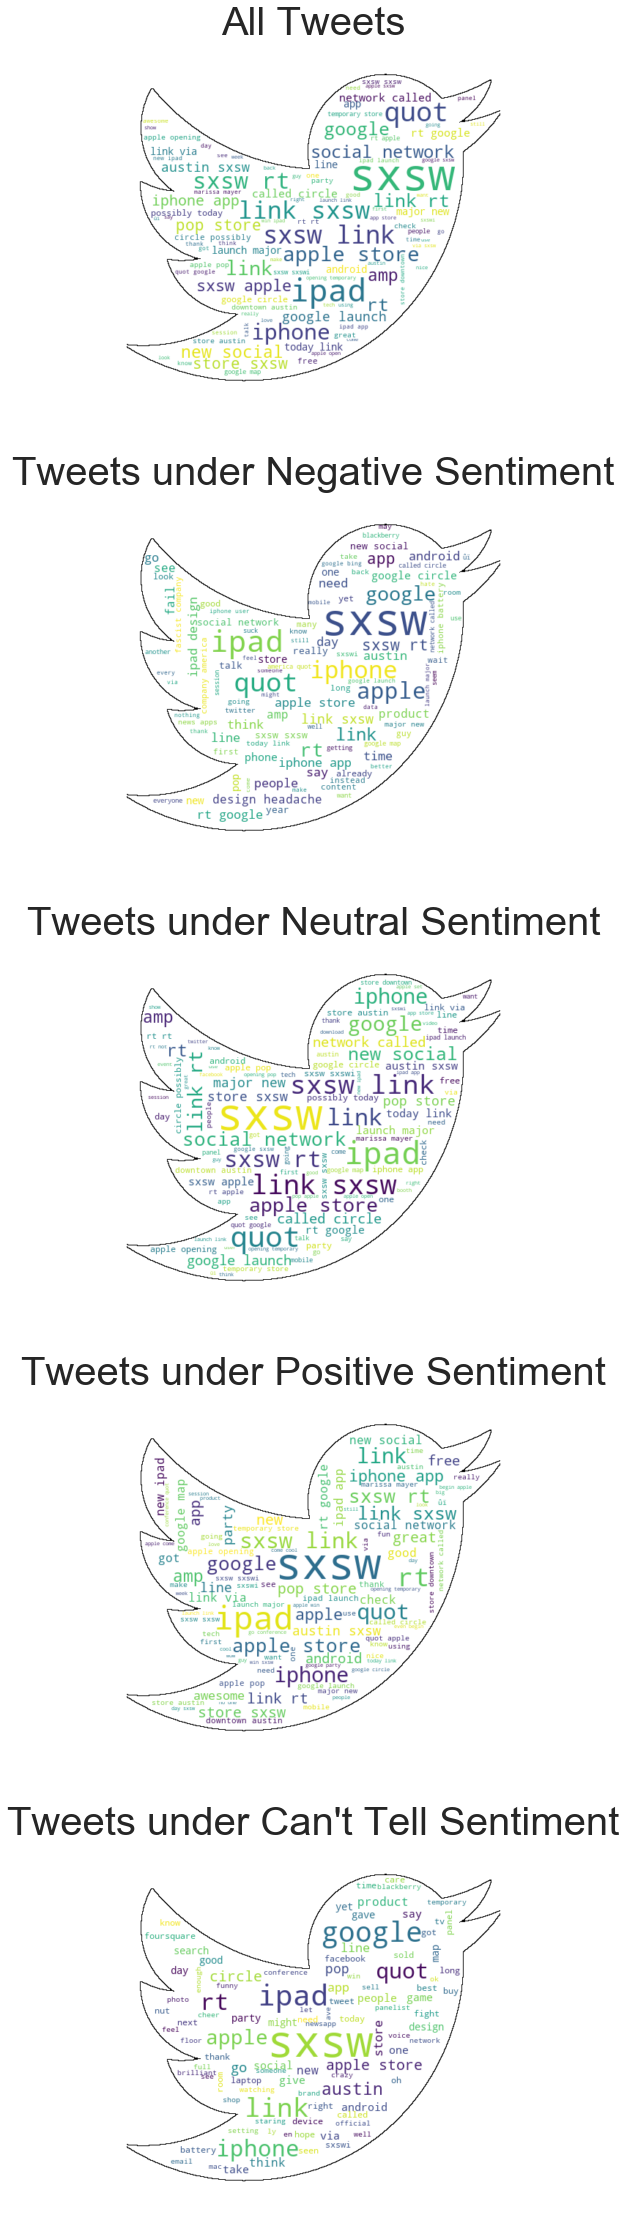

In [24]:
df_model['tweet'] = df_model['clean_text']  
createWC(df_model)

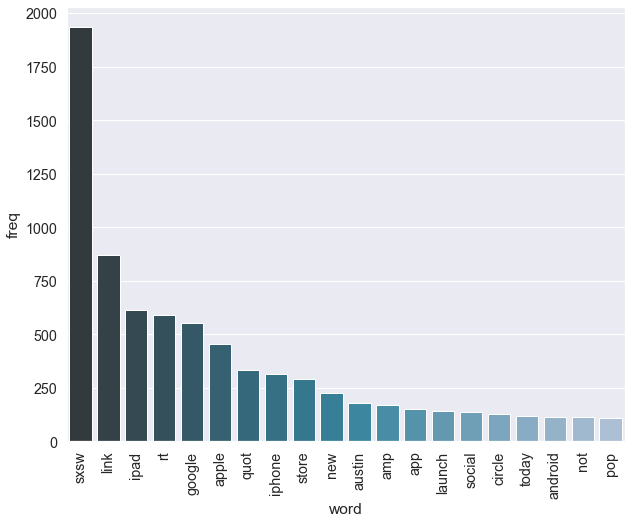

In [25]:
# CountVectorizer Classifier - Test data
cv = CountVectorizer()
bow = cv.fit_transform(test_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.xticks(rotation=90)
plt.show();

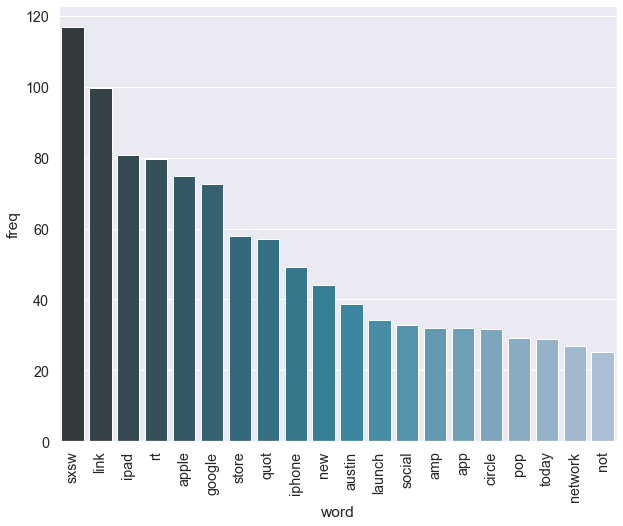

In [26]:
# TfidfVectorizer Classifier - Test Data
cv = TfidfVectorizer()
bow = cv.fit_transform(test_clean)
word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
word_counter = collections.Counter(word_freq)
word_counter_df = pd.DataFrame(word_counter.most_common(20), columns = ['word', 'freq'])
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d", ax=ax)
plt.xticks(rotation=90)
plt.show();

In [27]:
df_model.head()

,count_words,count_char,count_digit,count_mentions,count_hashtags,count_capital_words,count_fCap,count_Elgwords,count_excl_quest_marks,count_urls,count_emojis,sentiment,clean_text,tweet
0,12,75,0,0,3,0,0,0,0,0,0,1,sxswnui sxsw apple defining language touch different dialect becoming smaller,sxswnui sxsw apple defining language touch different dialect becoming smaller
1,19,117,0,0,2,0,3,0,1,0,0,1,learning ab google doodle doodle light funny amp innovative exception significant occasion googledoodle sxsw,learning ab google doodle doodle light funny amp innovative exception significant occasion googledoodle sxsw
2,26,98,0,1,1,2,2,0,0,0,0,2,one face ex stealing show yr rt quot sxsw apple school mkt expert quot link,one face ex stealing show yr rt quot sxsw apple school mkt expert quot link
3,20,100,2,0,3,1,1,0,0,0,0,0,iphone sxsw app would pretty awesome crash every min extended browsing fuckit illmakeitwork,iphone sxsw app would pretty awesome crash every min extended browsing fuckit illmakeitwork
4,14,60,0,0,1,1,3,0,0,0,0,1,line outside apple store austin waiting new ipad sxsw link,line outside apple store austin waiting new ipad sxsw link


In [28]:
tweet_0 = " ".join(i for i in df[df['sentiment']==0].tweet)
tweet_0

"This iPhone #SXSW app would b pretty awesome if it didn't crash every 10mins during extended browsing. #Fuckit #Illmakeitwork .@mention I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW. So I went the whole day w/out my laptop &amp; just used my iPad 1. Things I missed: FTP, cloudapp, fast typing, &amp; skype. #iPad #sxsw RT @mention 'Google lost its way by caring too much for the business vs. the users' - @mention #psych #sxsw I composed a tweet so acerbic and cynical about ipad users that my phone crashed and dumped all my apps. #twitterpower #sxsw #imthatgood @mention is about to talk about the mistakes he made building Netflix for the iPhone. #SXSW #netflixiphone You spent $1,000+ to come to SXSW. \r\n\r\nYou've already used iPad 1. \r\n\r\nThe wait is a couple city blocks. \r\n\r\nWhy? #ipad2 #SXSW {link} My tweeting from #sxsw been pretty non existent today thanks to the @mention iPhone app #fail - Hootsuite is th

In [29]:
df['tweet']=df['tweet'].map(lambda x: x.lower())

In [30]:
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags
# extracting hashtags from  tweets
HT_negative = hashtag_extract(df['tweet'][df['sentiment'] == 0])
HT_neutral = hashtag_extract(df['tweet'][df['sentiment'] == 1])
HT_positive = hashtag_extract(df['tweet'][df['sentiment'] == 2])
HT_cantell = hashtag_extract(df['tweet'][df['sentiment'] == 3])

# unnesting list
HT_neutral = sum(HT_neutral,[])
HT_negative = sum(HT_negative,[])
HT_positive = sum(HT_positive,[])
HT_cantell = sum(HT_cantell,[])

In [31]:
import nltk

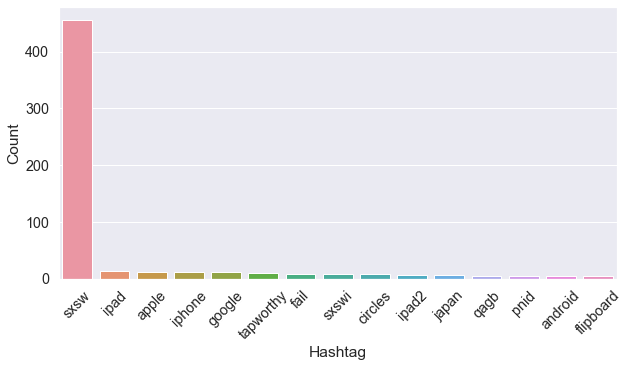

In [32]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 15 most frequent hashtags     
d = d.nlargest(columns="Count", n = 15) 
plt.figure(figsize=(10,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=45)
plt.show()

In [33]:
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer(stop_words = 'english')  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)


In [34]:
f1 = []
def run_model(predictors,target, model):
    X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.2, random_state=6)
    model.fit(X_train, y_train)
    y_scores = model.predict(X_test)
    print('Train Accuracy:\n',model.score(X_train,y_train).round(3))
    print('Validation Accuracy:\n',model.score(X_test,y_test).round(3))
    print('Classification Report:\n',classification_report(y_test, y_scores))
    print("Precision Score : ",precision_score(y_test, y_scores,average='weighted').round(3))
    print("Recall Score : ",recall_score(y_test, y_scores,average='weighted').round(3))

    # calculating the f1 score for the validation set
    print("F1 score :", f1_score(y_test, y_scores,average='weighted').round(3))
    f1.append(f1_score(y_test, y_scores,average='weighted').round(3))
    print("="*120)
    return f1


In [35]:
# Predictors
X = Xt
y = df_model['sentiment']

models = {'Logistic Regression':LogisticRegression()
          ,'Decision Tree':DecisionTreeClassifier()
          ,'Random Forest': RandomForestClassifier()
          ,'MNB':MultinomialNB()
          ,'SVC':SVC(kernel='linear', gamma = 6, random_state=0)}

j = 0
for i in models.items():
    print('='*50,list(models.keys())[j],'='*50)
    model = i[1]
    a = run_model(X, y, model)
    j=j+1
print('Max f1_score is {} in model {}'.format(max(a),list(models.keys())[a.index(max(a))]))

================================================== Logistic Regression ==================================================
Train Accuracy:
 0.758
Validation Accuracy:
 0.668
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.04      0.07        84
           1       0.67      0.93      0.78       859
           2       0.66      0.35      0.46       485
           3       0.00      0.00      0.00        27

    accuracy                           0.67      1455
   macro avg       0.46      0.33      0.33      1455
weighted avg       0.64      0.67      0.62      1455

Precision Score :  0.645
Recall Score :  0.668
F1 score : 0.617
================================================== Decision Tree ==================================================
Train Accuracy:
 0.992
Validation Accuracy:
 0.601
Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.18      0.21        84
    

In [36]:
# Now using SVC on train and test both with TF-IDF vectoriser

X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = tfidf.transform(df_test)


def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = SVC(kernel='linear', gamma = 6, random_state=0)   # SVC Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='weighted').round(3)
    return f1


#training
X = Xt
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred


# Storing the Id column of test data
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.635
1    1371
2    424 
0    24  
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [37]:
# Logistic Reg with TF-IDF Vectoriser

X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
tfidf = TfidfVectorizer()  #TF-IDF Vectoriser
Xt = tfidf.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = tfidf.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()        # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='weighted').round(4)
    return f1

#training
X = Xt
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred


# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.609
1    1447
2    365 
0    7   
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [38]:
# Logistic Reg with Count Vectorizer

X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
CV = CountVectorizer()   # CountVectorizer()
Xc = CV.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = CV.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()       # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='weighted').round(3)
    
    return f1

#trainning
X = Xc
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred



# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.658
1    1273
2    504 
0    41  
3    1   
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [39]:
# Logistic Reg with hashing Vectorizer
X = df_model['clean_text']
X1 = df1_model['clean_text']
y = df_model.sentiment
Hv = HashingVectorizer()       # HashinhVectorizer
Xh = Hv.fit_transform(X)

df_test = df1_model['clean_text']
df_test1 = Hv.transform(df_test)

def LogReg(X,y):
    global model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)
    model = LogisticRegression()         # LogisticRegression Model
    model.fit(X_train, y_train)
    y_score = model.predict(X_test)
    f1 = f1_score(y_test, y_score,average='weighted').round(3)
    return f1

#training
X = Xh
y = df_model.sentiment
f1 = LogReg(X,y)    
print('f1 score is:',f1)

#testing function
def prediction(test):
    y_pred = model.predict(test)
    return y_pred

# Storing the Id column
Id = df1[['tweet_id']]

#predicting on test file
y_pred = pd.DataFrame(prediction(df_test1),columns=['sentiment']) 
print(y_pred['sentiment'].value_counts())
submission = pd.concat([Id,y_pred['sentiment']],1)
submission.head()
# submission.to_csv('submission.csv',index=False)

f1 score is: 0.603
1    1475
2    339 
0    5   
Name: sentiment, dtype: int64


,tweet_id,sentiment
0,7506,1
1,7992,1
2,247,1
3,7688,2
4,3294,2


In [40]:
#  Final Model on CV and LogisticRegression Model